## Load data

In [24]:
# Import the dataset loading function from sklearn
from sklearn.datasets import fetch_openml

# Load the titanic dataset from openml
titanic = fetch_openml(name='titanic', version=1, as_frame=True)

In [25]:
data, label = titanic.data.copy(), titanic.target.copy()
data.head(5)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [26]:
data.dtypes

pclass        float64
name           object
sex          category
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [27]:
# look at the data
print("\n-- | Shape of the data -> (n_sample * n_feature) |--\n {}".format(data.shape))


-- | Shape of the data -> (n_sample * n_feature) |--
 (1309, 13)


In [28]:
label

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: category
Categories (2, object): [0, 1]

## Feature engineering: deal with missing values

In [29]:
data.isnull().sum()

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [30]:
# Check for missing values
print("-- # missing values --\n{}".format(data.isnull().sum()))

-- # missing values --
pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


### Simple drop out the features with too many missing values

In [31]:
# Remove 'cabin', 'boat', 'body' features
data = data.drop(['cabin', 'boat', 'body', 'home.dest'], axis=1)

In [32]:
data.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,S
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,S
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,S
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,S
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,S


### Imputation missing fare and embarked with sensible feature correlation

Text(2.6, 80, 'fare = $80')

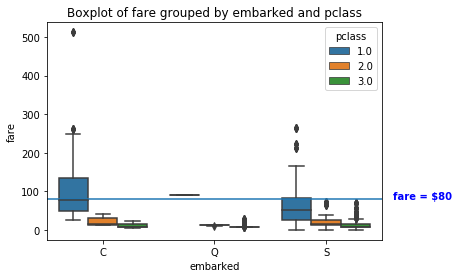

In [33]:
import seaborn as sns
boxplot = sns.boxplot(x='embarked', y='fare', data=data, hue='pclass')
boxplot.axhline(80)
boxplot.set_title("Boxplot of fare grouped by embarked and pclass")
boxplot.text(x=2.6, y=80, s="fare = $80", size='medium', color='blue', weight='bold')

In [34]:
data[data["embarked"].isnull()]

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
168,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0,NaN
284,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,NaN


In [35]:
# Impute missing value in embarked
data['embarked'][[168, 284]] = 'C'

In [36]:
data[data["fare"].isnull()]

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
1225,3.0,"Storey, Mr. Thomas",male,60.5,0.0,0.0,3701,NaN,S


In [37]:
# Impute missing value in fare
data["fare"][1225] = data.groupby(['embarked', 'pclass'])\
                            .get_group(('S', 3))['fare'] \
                                .median()

/home/qq/.virtualenvs/book/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Imputation missing age with naive statistical information

In [38]:
# Use median age to fill the missing ages
data["age"].fillna(data["age"].median(skipna=True), inplace=True)

##### NOTE: We could also use sensible value information such as the relationship betwee embarked and fare predictive relationship to fill the missing values of the age variable rather than directly use statistical median. 

In [39]:
print("\n-- # of missing values --\n{}".format(data.isnull().sum()))


-- # of missing values --
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64


## Feature engineering: name title extraction

In [40]:
data.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,S
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,S
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,S
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,S
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,S


In [41]:
data['title'] = data['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['title'].value_counts() 

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Mlle          2
Ms            2
Major         2
Capt          1
Lady          1
Don           1
Dona          1
Jonkheer      1
Countess      1
Mme           1
Sir           1
Name: title, dtype: int64

In [42]:
data['title'] = data['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['title'] = data['title'].replace('Mlle', 'Miss')
data['title'] = data['title'].replace('Ms', 'Miss')
data['title'] = data['title'].replace('Mme', 'Mrs')

data = data.drop(['name'], axis=1)

In [43]:
data.head()

,pclass,sex,age,sibsp,parch,ticket,fare,embarked,title
0,1.0,female,29.0000,0.0,0.0,24160,211.3375,S,Miss
1,1.0,male,0.9167,1.0,2.0,113781,151.5500,S,Master
2,1.0,female,2.0000,1.0,2.0,113781,151.5500,S,Miss
3,1.0,male,30.0000,1.0,2.0,113781,151.5500,S,Mr
4,1.0,female,25.0000,1.0,2.0,113781,151.5500,S,Mrs


## Feature engineering: categorical feature enoding

In [21]:
data['ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: ticket, dtype: object

In [22]:
import pandas as pd
encode_col_list = ['sex', 'embarked', 'title']
for i in encode_col_list:
    data = pd.concat([data, pd.get_dummies(data[i], prefix=i)],axis=1)
    data.drop(i, axis = 1, inplace=True)
    
# direct drop the ticket feature here since it is a categorical feature with too high levels
data.drop('ticket', axis = 1, inplace=True)
data.shape

(1309, 15)

In [177]:
data.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare
0,1.0,29.0000,0.0,0.0,211.3375,1,0,0,0,1,0,1,0,0,0
1,1.0,0.9167,1.0,2.0,151.5500,0,1,0,0,1,1,0,0,0,0
2,1.0,2.0000,1.0,2.0,151.5500,1,0,0,0,1,0,1,0,0,0
3,1.0,30.0000,1.0,2.0,151.5500,0,1,0,0,1,0,0,1,0,0
4,1.0,25.0000,1.0,2.0,151.5500,1,0,0,0,1,0,0,0,1,0


In [178]:
data.dtypes

pclass          float64
age             float64
sibsp           float64
parch           float64
fare            float64
sex_female        uint8
sex_male          uint8
embarked_C        uint8
embarked_Q        uint8
embarked_S        uint8
title_Master      uint8
title_Miss        uint8
title_Mr          uint8
title_Mrs         uint8
title_Rare        uint8
dtype: object

## Split Training / Testing

#### NOTE: Here we do feature engineering first and then do the split.

In [179]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = data[:891], data[891:], label[:891], label[891:]

print("--Shape of the training data--\n {}".format(X_train.shape))
print("\n--Shape of the testing data--\n {}".format(X_test.shape))

--Shape of the training data--
 (891, 15)

--Shape of the testing data--
 (418, 15)


## Build up a Decision Tree, a Random Forest & a GBDT classifier

In [180]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt 

### decision tree

In [181]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(X_train, y_train)

# Now predict the value of the digit on the test set:
y_pred_test = dt_clf.predict(X_test)

Test accuracy: 71.05 %


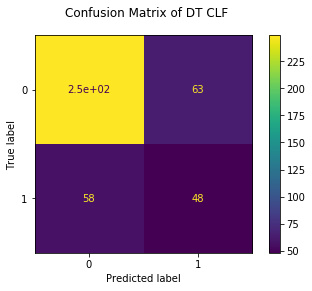

In [184]:
# Display the testing results
acc = accuracy_score(y_test, y_pred_test)
print("Test accuracy: {:.2f} %".format(acc * 100))

disp = plot_confusion_matrix(dt_clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix of DT CLF")

plt.show()

### random forest 

Random forest test accuracy: 72.01 %


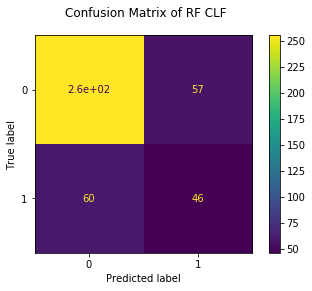

In [187]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Now predict the value of the digit on the test set:
y_pred_test = rf_clf.predict(X_test)


# Display the testing results
acc = accuracy_score(y_test, y_pred_test)
print("Random forest test accuracy: {:.2f} %".format(acc * 100))

disp = plot_confusion_matrix(rf_clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix of RF CLF")

plt.show()

### gradient boosted decision tree classifier

GBDT test accuracy: 72.97 %


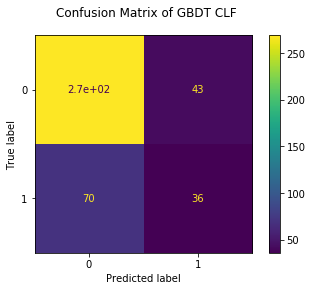

In [188]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbdt_clf.fit(X_train, y_train)  
y_pred_test = gbdt_clf.predict(X_test)  

# Now predict the value of the digit on the test set:
y_pred_test = gbdt_clf.predict(X_test)


# Display the testing results
acc = accuracy_score(y_test, y_pred_test)
print("GBDT test accuracy: {:.2f} %".format(acc * 100))

disp = plot_confusion_matrix(gbdt_clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix of GBDT CLF")

plt.show()


### Both

In [189]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Train and test Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_test = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_test)

# Train and test GBDT
gbdt_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbdt_clf.fit(X_train, y_train)  
y_pred_test = gbdt_clf.predict(X_test)  
acc_gbdt = accuracy_score(y_test, y_pred_test)

# Pring the results
print("Random forest test accuracy: {:.2f} %".format(acc_rf * 100))
print("GBDT test accuracy: {:.2f} %".format(acc_gbdt * 100))

Random forest test accuracy: 72.01 %
GBDT test accuracy: 72.97 %
